In [2]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple , deque
from itertools import  count

import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


In [3]:
env = gym.make('LunarLander-v2')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Replay Memory


In [4]:
Transition = namedtuple("Transition" , ('state' , 'action' , 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

Q-network

In [5]:
class DQN(nn.Module):

    def __init__(self , n_observations , n_actions):
        super(DQN , self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128 , 128)
        self.layer3 = nn.Linear(128 , n_actions)

    def forward(self , x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [6]:


BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n

state , info  = env.reset()

n_observations = len(state)

policy_net = DQN(n_observations ,n_actions).to(device)
target_net = DQN(n_observations , n_actions).to(device)

target_net.load_state_dict(policy_net.state_dict())


<All keys matched successfully>

In [7]:
optimizer = optim.AdamW(policy_net.parameters() , lr=LR , amsgrad= True)

memory = ReplayMemory(10000)

steps_done = 0
episode_durations = []


In [8]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done/EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():


            return policy_net(state).max(1).indices.view(1,1)
        
    else:
        return torch.tensor([[env.action_space.sample()]] , device= device ,dtype= torch.long)
    

In [9]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
        
        

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

Training loop



In [10]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch


    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()



Complete


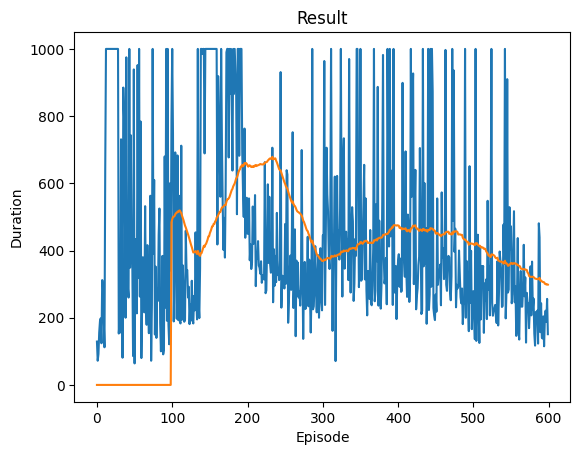

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [12]:
# # Save the entire model
torch.save(policy_net, 'policy_net_complete.pth')
torch.save(target_net, 'target_net_complete.pth')


In [13]:
# Load the entire model
policy_net = torch.load('policy_net_complete.pth', map_location=device)
policy_net.eval()  # Set the network to evaluation mode


DQN(
  (layer1): Linear(in_features=8, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=4, bias=True)
)

In [14]:
def select_best_action(state):
    with torch.no_grad():
        return policy_net(state).max(1).indices.view(1, 1)


In [15]:
num_test_episodes = 1
total_rewards = []

for i_episode in range(num_test_episodes):
    state, info = env.reset()  # Adjusted to unpack the state and info
    state = torch.tensor(state, device=device, dtype=torch.float32).unsqueeze(0)
    total_reward = 0
    while True:
        action = select_best_action(state)
        next_state, reward, done, info, *rest = env.step(action.item())  # Adjusted to capture extra values in *rest
        total_reward += reward
        if done:
            break
        next_state = torch.tensor(next_state, device=device, dtype=torch.float32).unsqueeze(0)
        state = next_state

    total_rewards.append(total_reward)
    print(f"Episode {i_episode+1}: Total Reward = {total_reward}")

average_reward = sum(total_rewards) / num_test_episodes
print(f'Average total reward over {num_test_episodes} episodes: {average_reward}')


Episode 1: Total Reward = -292.1885511133249
Average total reward over 1 episodes: -292.1885511133249
